In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import xarray as xr
import numpy as np
import matplotlib
from importlib.resources import files
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import binned_statistic_2d

from cloud_filtering.surface_algorithm import surface_mask_simulations

style_path = files("cloud_filtering.plotting") / "plotstyling.mplstyle"
plt.style.use(style_path)

In [62]:
filename = "../../../DataStorage/AWS/aws_database_2025-11-10.nc"
#filename = "../../../DataStorage/AWS/Arctic/combined_v3.nc"
ds = xr.open_dataset(filename)

In [63]:
surface_mask, cond4_mask, cond5_mask = surface_mask_simulations(ds)


In [64]:
mask_31 = surface_mask[31]
mask_32 = surface_mask[32]
mask_33 = surface_mask[33]
mask_34 = surface_mask[34]
mask_35 = surface_mask[35]
mask_36 = surface_mask[36]


cond4_33 = cond4_mask[33]
cond5_33 = cond5_mask[33]

mask_surf_cond4 = ~cond4_33 & mask_33
mask_surf_cond5 = ~cond5_33 & mask_33
print(np.sum(mask_surf_cond4))
print(np.sum(mask_surf_cond5))

5079
5904


In [51]:
group3_channels = [31, 32, 33, 34, 35, 36]

In [65]:

def contour2d_stat(ax, x, y, z, xbins, ybins, xlabel, ylabel, zlabel,
                   statistic="mean",
                   vmin=None, vmax=None,
                   log_norm=True,
                   levels=np.logspace(-3,2,6),
                   cmap="copper_r"):

    # drop non-finite
    x = np.asarray(x); y = np.asarray(y); z = np.asarray(z)
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[m]; y = y[m]; z = z[m]

    stat, xe, ye, _ = binned_statistic_2d(
        x, y, z,
        statistic=statistic,
        bins=[xbins, ybins],
    )

    Xc = 0.5 * (xe[:-1] + xe[1:])
    Yc = 0.5 * (ye[:-1] + ye[1:])

    stat_finite = stat[np.isfinite(stat)]
    if vmin is None:
        vmin = np.nanmin(stat_finite) if stat_finite.size else 0.0
    if vmax is None:
        vmax = np.nanmax(stat_finite) if stat_finite.size else 1.0

    if log_norm:
        # log needs positive values
        stat = stat.copy()
        stat[stat <= 0] = np.nan
        vmin = max(vmin, np.nanmin(stat[np.isfinite(stat)]))
        #levels = np.logspace(np.log10(vmin), np.log10(vmax), n_levels)
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        #levels = np.linspace(vmin, vmax, n_levels)
        norm = None

    cf = ax.contourf(
        Xc, Yc, stat.T,
        levels=levels,
        norm=norm,
        cmap=cmap,
        extend="both",
    )
    plt.colorbar(cf, ax=ax, label=f"{statistic}({zlabel})")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(ls=":")

    return cf


/tmp/ipykernel_36821/3852969970.py:31: RuntimeWarning: divide by zero encountered in divide
  slope = (tb33-tb44)/(tb33-tb43)
/tmp/ipykernel_36821/3852969970.py:41: UserWarning: Log scale: values of z <= 0 have been masked
  cf = ax.contourf(Xc, Yc, H.T, levels=levels, norm=LogNorm(), cmap="copper_r")


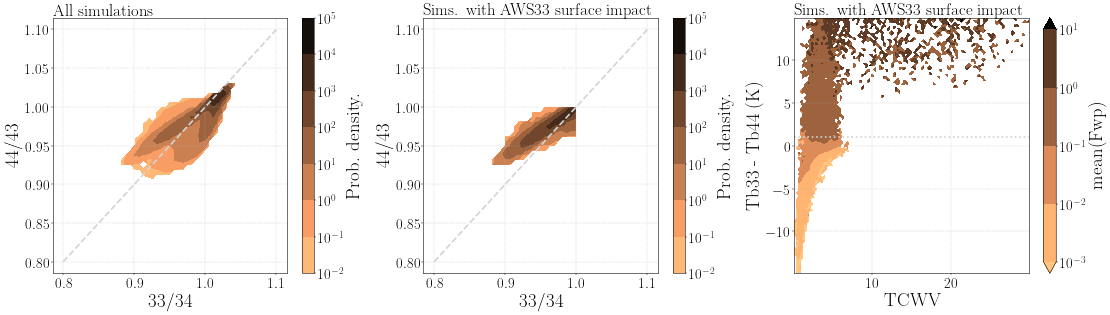

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# ----------------------------------
# Data
# ----------------------------------
dTb = ds.Ta_Allsky_AWS33.values - ds.Ta_Allsky_AWS44.values
tcwv = ds.H2O_Column.values
fwp  = ds.Fwp.values
tb32 = ds.Ta_Allsky_AWS32.values
tb33 = ds.Ta_Allsky_AWS33.values
tb34 = ds.Ta_Allsky_AWS34.values
tb36 = ds.Ta_Allsky_AWS36.values
tb44 = ds.Ta_Allsky_AWS44.values
tb43 = ds.Ta_Allsky_AWS43.values


# mask for only negative 33-34
mask = (tb33 - tb34) < 0
mask = mask & ((tb44 - tb43) < 0)
mask = mask & (tb33-tb44 < 15)
dTb_masked = dTb[mask]
tcwv_masked = tcwv[mask]
fwp_masked = fwp[mask]
tb33_masked = tb33[mask]
tb34_masked = tb34[mask]
tb36_masked = tb36[mask]
tb43_masked = tb43[mask]
tb44_masked = tb44[mask]
tb32_masked = tb32[mask]

slope = (tb33-tb44)/(tb33-tb43)

def contour2d(ax, x, y, xbins, ybins, xlabel, ylabel, levels=np.logspace(-5,2,8)):

    H, xe, ye = np.histogram2d(x, y, bins=[xbins, ybins], density=True)
    #H = gaussian_filter(H, sigma=1.0)  # smoother contours

    Xc = 0.5 * (xe[:-1] + xe[1:])
    Yc = 0.5 * (ye[:-1] + ye[1:])

    cf = ax.contourf(Xc, Yc, H.T, levels=levels, norm=LogNorm(), cmap="copper_r")
    plt.colorbar(cf, ax=ax, label="Prob. density.")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.grid(ls=":")


# ----------------------------------
# 1) All simulations
# ----------------------------------
tcwv_bins = np.linspace(0, 30, 120)
dTb_bins  = np.linspace(-15, 15, 120)

fraction_bins = np.linspace(0.8, 1.1, 50)

contour2d(
    axes[0],
    tb33/tb34, tb44/tb43,
    fraction_bins, fraction_bins,
    "33/34",
    "44/43",
    levels=np.logspace(-2,5,8)
)
axes[0].plot(fraction_bins, fraction_bins, ls="--", c="lightgrey")

axes[0].set_title("All simulations", loc="left")

# ----------------------------------
# 2) Surface impacted simulations
# ----------------------------------

contour2d(
    axes[1],
    tb33_masked/tb34_masked, tb44_masked/tb43_masked,
    fraction_bins, fraction_bins,
    "33/34",
    "44/43",
    levels=np.logspace(-2,5,8)
)
axes[1].plot(fraction_bins, fraction_bins, ls="--", c="lightgrey")
#axes[1].set_xscale("log")

axes[1].set_title("Sims. with AWS33 surface impact", loc="left")

# ----------------------------------
# 3) dTb vs TCWV, mean FWP
# ----------------------------------
tb_bins = np.linspace(80, 300, 120)
fwp_bins = np.logspace(-3, 2, 120)

contour2d_stat(
    axes[2],
    tcwv_masked, dTb_masked, fwp_masked,
    tcwv_bins, dTb_bins,
    "TCWV",
    "Tb33 - Tb44 (K)",
    "Fwp",
    statistic="mean",
    vmin=1e-3, vmax=1e2,      # adjust as you like
    log_norm=True,
    levels=np.logspace(-3,1,5),
    cmap="copper_r",
)
#axes[2].plot(dTb_bins, dTb_bins, ls=":", c="lightgrey")
axes[2].axhline(1, ls=":", c="lightgrey")

axes[2].set_title("Sims. with AWS33 surface impact", loc="left")


plt.tight_layout()

plt.savefig(
        f"../figures/surface_handling/test_of_fraction_limit_arctic.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
    )



5293


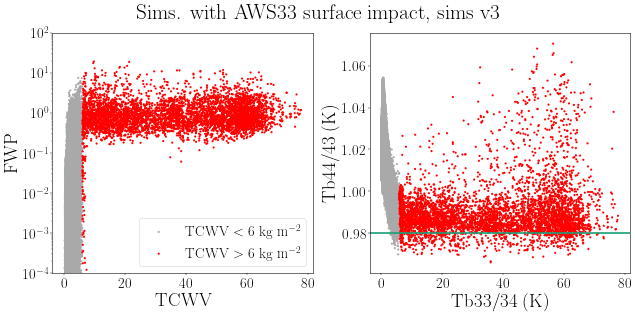

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ----------------------------------
# Data
# ----------------------------------
dTb = ds.Ta_Allsky_AWS33.values - ds.Ta_Allsky_AWS44.values
tcwv = ds.H2O_Column.values
fwp  = ds.Fwp.values
tb32 = ds.Ta_Allsky_AWS32.values
tb33 = ds.Ta_Allsky_AWS33.values
tb34 = ds.Ta_Allsky_AWS34.values
tb35 = ds.Ta_Allsky_AWS35.values
tb36 = ds.Ta_Allsky_AWS36.values
tb44 = ds.Ta_Allsky_AWS44.values
tb43 = ds.Ta_Allsky_AWS43.values


ok_cases = (tb33 - tb34) < 0
ok_cases = ok_cases & ((tb44 - tb43) < 0)
ok_cases = ok_cases & (tb33-tb44 < 15)

#ok_cases = ok_cases & (tb33-tb44 > 0)

annoying_cases = ok_cases & (tcwv > 6)
ok_cases = ok_cases & (tcwv < 6)

#annoying_cases = annoying_cases & (((tb44*tb34)/(tb33*tb43)) < 0.99)

print(np.sum(annoying_cases))
fwp_bins = np.logspace(-3, 2, 120)

"""
axes[1].scatter(
    (tb33/tb34)[ok_cases], (tb44/tb43)[ok_cases],
    c="darkgrey", alpha=0.1, s=15,
)

axes[1].scatter(
    (tb33/tb34)[annoying_cases], (tb44/tb43)[annoying_cases],
    c="red", alpha=0.1, s=25,
)

"""
axes[1].scatter(
    tcwv[ok_cases], (tb44*tb34)[ok_cases]/(tb33*tb43)[ok_cases],
    c="darkgrey", alpha=1, s=15,
)

axes[1].scatter(
    tcwv[annoying_cases], (tb44*tb34)[annoying_cases]/(tb33*tb43)[annoying_cases],
    c="red", alpha=1, s=15,
)

axes[1].set_xlabel("Tb33/34 (K)")
axes[1].set_ylabel("Tb44/43 (K)")

#axes[1].plot(np.linspace(0.88,1,100), np.linspace(0.88,1,100), ls="--", c="lightgrey")
axes[1].axhline(0.98)


# ----------------------------------
# 3) AWS33 vs TCWV
# ----------------------------------

axes[0].scatter(
    tcwv[ok_cases], fwp[ok_cases],
    c="darkgrey",
    s=15,
    label=r"TCWV $<$ 6 kg m$^{-2}$",
)

axes[0].scatter(
    tcwv[annoying_cases], fwp[annoying_cases],
    c="red",
    s=15,
    label=r"TCWV $>$ 6 kg m$^{-2}$",
)

axes[0].legend()

axes[0].set_xlabel("TCWV")
axes[0].set_ylabel("FWP")
axes[0].set_yscale("log")
axes[0].set_ylim([1e-4, 1e2])

fig.suptitle("Sims. with AWS33 surface impact, sims v3")


fig.tight_layout()

plt.savefig(
        f"../figures/surface_handling/test_of_fraction_limit_2_arctic_with_v3.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
    )


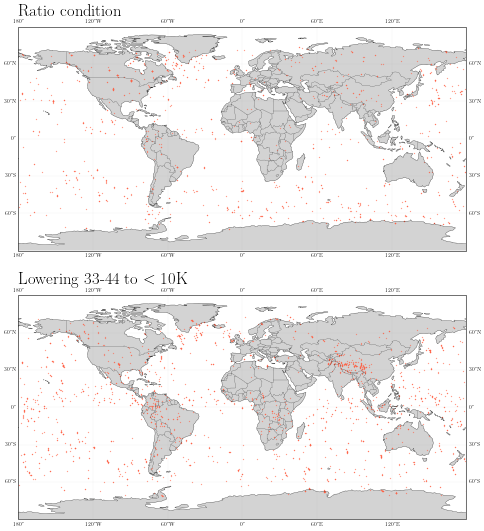

In [71]:
proj = ccrs.PlateCarree()
#proj = ccrs.NorthPolarStereo()

fig, axes = plt.subplots(2, 1,
    figsize=(24, 16),
    subplot_kw={"projection": proj}
)

extent = [-180, 190, -90, 90]

for ax in axes.flatten():
    #ax.set_extent([60, 90, 0, 50], crs=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')


axes[0].scatter(
    ds.Longitude.values[mask_surf_cond4 & ~mask_surf_cond5],
    ds.Latitude.values[mask_surf_cond4 & ~mask_surf_cond5],
    color="tomato",
    s=2,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)

axes[0].set_title("Ratio condition", loc="left")


axes[1].scatter(
    ds.Longitude.values[mask_surf_cond5 & ~mask_surf_cond4],
    ds.Latitude.values[mask_surf_cond5 & ~mask_surf_cond4],
    color="tomato",
    s=2,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
)

axes[1].set_title(r"Lowering 33-44 to $<$ 10K", loc="left")

plt.savefig(
        f"../figures/surface_handling/fraction_impact_demonstration",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
    )



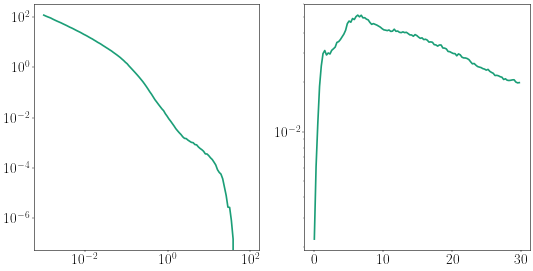

In [63]:
counts, _ = np.histogram(ds.Fwp.values[mask_surf_cond4], bins=fwp_bins, density=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax.plot(fwp_bins[:-1], counts)

ax.set_xscale("log")
ax.set_yscale("log")

counts, _ = np.histogram(ds.H2O_Column.values[mask_surf_cond4], bins=tcwv_bins, density=True)

ax2.plot(tcwv_bins[:-1], counts)

#ax2.set_xscale("log")
ax2.set_yscale("log")

In [ ]:
proj = ccrs.PlateCarree()
#proj = ccrs.NorthPolarStereo()

fig, axes_2d = plt.subplots(2, 3,
    figsize=(32, 16),
    subplot_kw={"projection": proj}
)

axes = axes_2d.flatten()

extent = [-180, 190, -90, 90]

for ax in axes.flatten():
    #ax.set_extent([60, 90, 0, 50], crs=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')

for i, channel in enumerate(group3_channels):

    axes[i].scatter(
        ds.Longitude.values[surface_mask[channel]],
        ds.Latitude.values[surface_mask[channel]],
        color="tomato",
        s=1,
        alpha=0.5,
        transform=ccrs.PlateCarree(),
    )

    n_cases = len(ds.Longitude.values[surface_mask[channel]])
    axes[i].set_title(f"AWS{channel}, cases masked = {n_cases}", loc="left")

    n_cases_highlats = len(np.where(np.abs(ds.Latitude.values[surface_mask[channel]]) > 60)[0])
    n_cases_tropical = len(np.where(np.abs(ds.Latitude.values[surface_mask[channel]]) < 30)[0])
    
    print("Total cases masked: ", n_cases)
    print("Total cases masked at higher lats: ", n_cases_highlats)
    print("Total cases masked in tropics: ", n_cases_tropical)
    

fig.tight_layout()


plt.savefig(
        f"../figures/surface_handling/simulations_with_surface_filter.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
    )


In [ ]:
proj = ccrs.PlateCarree()
#proj = ccrs.NorthPolarStereo()

fig, axes_2d = plt.subplots(2, 3,
    figsize=(32, 16),
    subplot_kw={"projection": proj}
)
axes = axes_2d.flatten()

extent = [-180, 190, -90, 90]

for ax in axes.flatten():
    #ax.set_extent([60, 90, 0, 50], crs=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor="white")
    ax.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')


# for training: include previous and next variants also
# for example: model(35-36) will include data where 34 not masked
# so only need to check if 33 masked
# but want to make sure that not *all* are masked
"""
    31   32    33    34    35    36
1.  x    x
2.  x    x     x     x 
3.  x    x     x     x     x     x
4. 
5.  x    x     x
6.  x

variant 1 (centred on 31 being not masked): include cases 4, 6. not 32 masked
variant 2 (centred on 32 being not masked): include cases 1, 4, 6: not 33 masked
variant 3 (centred on 33 being not masked): include cases 1, 6, 5: 31 masked. don't want cases 2 and 3, so 34 not masked.
variant 4: include cases 1, 5, 2: 31, 32 masked, don't want case 3, so 35 not masked. 
variant 5: include cases 2, 5: 33 masked, 36 not masked
case 3 never included.
so channel-2 masked, channel +1 not masked
"""
training_set_variant_1 = ~mask_32
training_set_variant_2 = ~mask_33
training_set_variant_3 = mask_31 & ~mask_34
training_set_variant_4 = mask_32 & ~mask_35
training_set_variant_5 = mask_33 & ~mask_36

training_set_variants = [training_set_variant_1, training_set_variant_2, training_set_variant_3, training_set_variant_4, training_set_variant_5]

for i in range(len(training_set_variants)):
    
    axes[i].scatter(
        ds.Longitude.values[training_set_variants[i]],
        ds.Latitude.values[training_set_variants[i]],
        color="tomato",
        s=0.1,
        alpha=0.5,
        transform=ccrs.PlateCarree(),
    )

    n_cases = len(ds.Longitude.values[training_set_variants[i]])

    axes[i].set_title(f"Training set for variant {i+1}, cases = {n_cases}")

axes[5].remove()

extent_str = "_".join(map(str, extent))

fig.tight_layout()

plt.savefig(
        f"../figures/surface_handling/training_sets_for_model_variants.png",
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        dpi=200,
    )
